In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/project1/

/content/drive/My Drive/project1


In [3]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from skimage.transform import resize
from sklearn.metrics import recall_score , precision_score , confusion_matrix,mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import pickle
%matplotlib inline

In [4]:
Glaucoma_images = []
Non_Glaucoma_images = []

for root, dirs, files in os.walk('./datasets/Glaucoma/'):
    for file in files:
            Glaucoma_images.append(os.path.join(root, file))
            
for root, dirs, files in os.walk('./datasets/Non Glaucoma/'):
    for file in files:
            Non_Glaucoma_images.append(os.path.join(root, file))

In [5]:
n_Glaucoma_images = len(Glaucoma_images)
n_non_Glaucoma_images = len(Non_Glaucoma_images)
img_shape = mpimg.imread(Glaucoma_images[1]).shape
print('No. of Glaucoma images: ', n_Glaucoma_images)
print('No of non-Glaucoma images: ', n_non_Glaucoma_images)
print('Image shape: ', img_shape)

No. of Glaucoma images:  396
No of non-Glaucoma images:  309
Image shape:  (229, 229, 3)


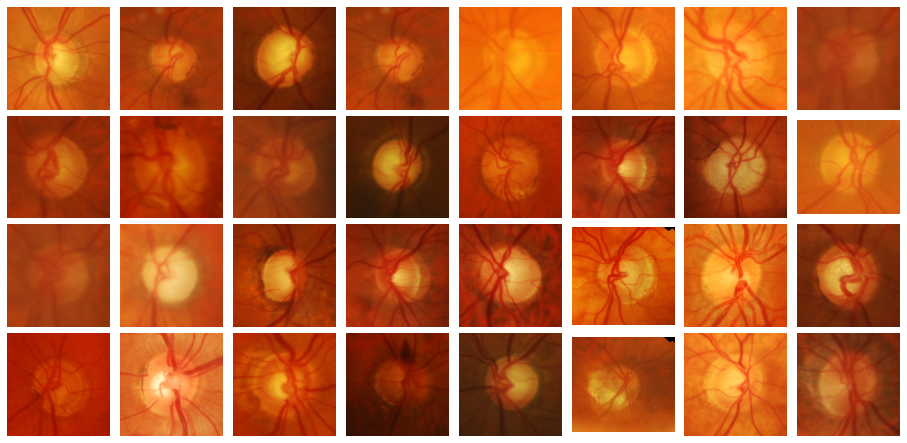

In [6]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(Glaucoma_images[np.random.randint(0,n_Glaucoma_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('Glaucoma_samples.png')

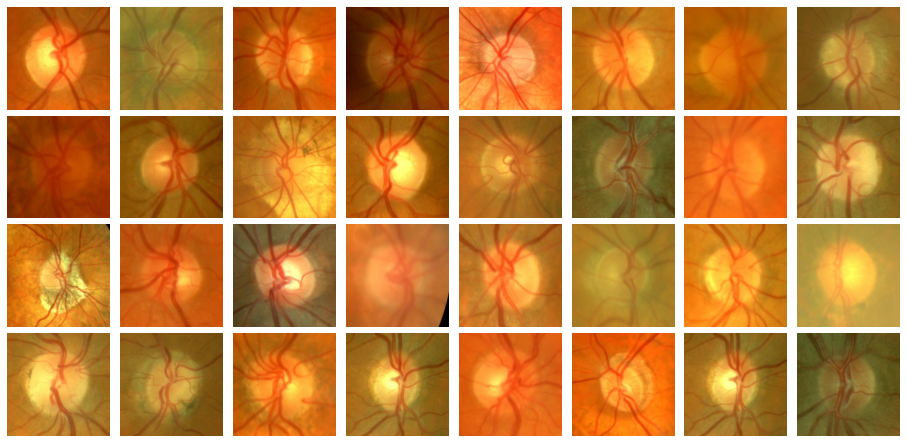

In [7]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(Non_Glaucoma_images[np.random.randint(0,n_non_Glaucoma_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('non_Glaucoma_samples.png')

In [8]:
# Compute binned color features by scaling images down 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Extract feature wrapper that extracts and combines all features
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = cv2.resize(image,(150,150))
        # apply color conversion if other than 'RGB' 
            
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

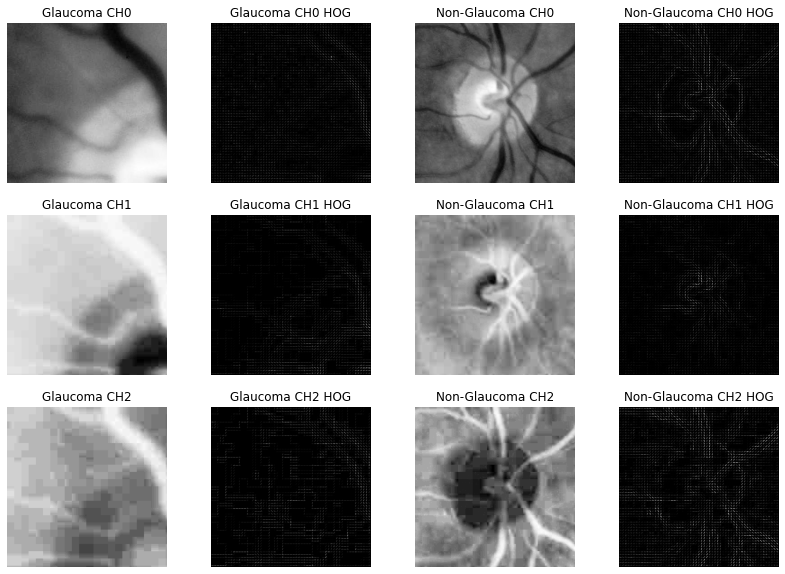

In [9]:
Glaucoma_test = mpimg.imread(Glaucoma_images[250])
Glaucoma_test = cv2.cvtColor(Glaucoma_test, cv2.COLOR_RGB2YCrCb)
non_Glaucoma_test = mpimg.imread(Non_Glaucoma_images[300])
non_Glaucoma_test = cv2.cvtColor(non_Glaucoma_test, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([Glaucoma_test, non_Glaucoma_test], ['Glaucoma', 'Non-Glaucoma']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=9, pix_per_cell=6, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.savefig('HOG_comparison.png')

In [10]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

Glaucoma_features = extract_features(Glaucoma_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

In [11]:
non_Glaucoma_features = extract_features(Non_Glaucoma_images,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

In [12]:
# Preserve State to compare parameter tuning 
rand_state = np.random.randint(0, 100)

# Create an array stack of feature vectors
X = np.vstack((Glaucoma_features, non_Glaucoma_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Removing features with low variance var[x] = p(1-p)
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.9*(1-0.9)))
scaled_X = sel.fit_transform(scaled_X)

# Define the labels vector
y = np.hstack((np.ones(len(Glaucoma_features)), np.zeros(len(non_Glaucoma_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15)
print(X_train[0].shape)
print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

(34349,)
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 34349


In [13]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test))
print('For these',n_predict, 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print('Test rms of SVC = ',mean_squared_error(y_test,  svc.predict(X_test), squared=False))
print('Test recall of SVC = ',recall_score(y_test, svc.predict(X_test), average=None))
print('Test precision of SVC = ',precision_score(y_test, svc.predict(X_test), average=None))
print('confusion_matrix of SVC = ',confusion_matrix(y_test, svc.predict(X_test)))

1.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9057
My SVC predicts:      [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
For these 10 labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
0.00967 Seconds to predict 10 labels with SVC
Test rms of SVC =  0.3071475584169756
Test recall of SVC =  [0.9787234  0.84745763]
Test precision of SVC =  [0.83636364 0.98039216]
confusion_matrix of SVC =  [[46  1]
 [ 9 50]]


In [14]:
# Use a LogisticRegression 
logistic = LogisticRegression(random_state=0)

# Check the training time for the logistic
t=time.time()
logistic.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train logistic...')
# Check the score of the logistic
print('Test Accuracy of logistic = ', round(logistic.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My logistic predicts:     ', logistic.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with logistic')

print('Test rms of logistic = ',mean_squared_error(y_test,  logistic.predict(X_test), squared=False))
print('Test recall of logistic= ',recall_score(y_test, logistic.predict(X_test), average=None))
print('Test precision of logistic = ',precision_score(y_test, logistic.predict(X_test), average=None))
print('confusion_matrix of logistic = ',confusion_matrix(y_test, logistic.predict(X_test)))

3.53 Seconds to train logistic...
Test Accuracy of logistic =  0.9434
My logistic predicts:      [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
For these labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
0.00932 Seconds to predict labels with logistic
Test rms of logistic =  0.23791547571544325
Test recall of logistic=  [0.93617021 0.94915254]
Test precision of logistic =  [0.93617021 0.94915254]
confusion_matrix of logistic =  [[44  3]

In [15]:
# Use a  K-Nearest Neighbors (K-NN)
neigh = KNeighborsClassifier(n_neighbors=2)
# Check the training time for the K-Nearest Neighbors (K-NN)
t=time.time()
neigh.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train K-Nearest Neighbors (K-NN)...')
# Check the score of the K-Nearest Neighbors (K-NN)
print('Test Accuracy of K-Nearest Neighbors (K-NN) = ', round(neigh.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My K-Nearest Neighbors (K-NN) predicts:     ', neigh.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with K-Nearest Neighbors (K-NN)')
print('Test rms of K-Nearest Neighbors (K-NN) = ',mean_squared_error(y_test,  neigh.predict(X_test), squared=False))
print('Test recall of K-Nearest Neighbors (K-NN)= ',recall_score(y_test, neigh.predict(X_test), average=None))
print('Test precision of K-Nearest Neighbors (K-NN) = ',precision_score(y_test, neigh.predict(X_test), average=None))
print('confusion_matrix of K-Nearest Neighbors (K-NN) = ',confusion_matrix(y_test, neigh.predict(X_test)))

0.02 Seconds to train K-Nearest Neighbors (K-NN)...
Test Accuracy of K-Nearest Neighbors (K-NN) =  0.8396
My K-Nearest Neighbors (K-NN) predicts:      [1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]
For these labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
0.2087 Seconds to predict labels with K-Nearest Neighbors (K-NN)
Test rms of K-Nearest Neighbors (K-NN) =  0.40047142031681365
Test recall of K-Nearest Neighbors (K-NN)=  [0.76595745

In [16]:
# Use a  Naive Bayes 
gnb = GaussianNB()

# Check the training time for the Naive Bayes
t=time.time()
gnb.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Naive Bayes...')
# Check the score of the Naive Bayes
print('Test Accuracy of Naive Bayes = ', round(gnb.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My Naive Bayes predicts:     ', gnb.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Naive Bayes')
print('Test rms of Naive Bayes = ',mean_squared_error(y_test,  gnb.predict(X_test), squared=False))
print('Test recall of Naive Bayes= ',recall_score(y_test, gnb.predict(X_test), average=None))
print('Test precision of Naive Bayes = ',precision_score(y_test, gnb.predict(X_test), average=None))
print('confusion_matrix of Naive Bayes = ',confusion_matrix(y_test, gnb.predict(X_test)))

0.22 Seconds to train Naive Bayes...
Test Accuracy of Naive Bayes =  0.8962
My Naive Bayes predicts:      [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
For these labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
0.03475 Seconds to predict labels with Naive Bayes
Test rms of Naive Bayes =  0.3221390769615825
Test recall of Naive Bayes=  [0.87234043 0.91525424]
Test precision of Naive Bayes =  [0.89130435 0.9       ]
confusion_matrix of 

In [17]:
# Use a Decision Tree Classification
DTC = DecisionTreeClassifier(random_state=0)

# Check the training time for the Decision Tree Classification
t=time.time()
DTC.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Decision Tree Classification...')
# Check the score of the Decision Tree Classification
print('Test Accuracy of Decision Tree Classification = ', round(DTC.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My Decision Tree Classification predicts:     ', DTC.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Decision Tree Classification')
print('Test rms of Decision Tree Classification = ',mean_squared_error(y_test,  DTC.predict(X_test), squared=False))
print('Test recall of Decision Tree Classification= ',recall_score(y_test, DTC.predict(X_test), average=None))
print('Test precision of Decision Tree Classification = ',precision_score(y_test, DTC.predict(X_test), average=None))
print('confusion_matrix of Decision Tree Classification = ',confusion_matrix(y_test, DTC.predict(X_test)))

9.7 Seconds to train Decision Tree Classification...
Test Accuracy of Decision Tree Classification =  0.7925
My Decision Tree Classification predicts:      [1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.]
For these labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
0.00887 Seconds to predict labels with Decision Tree Classification
Test rms of Decision Tree Classification =  0.45557345160942025
Test recall of Decision Tree Classification= 

In [18]:
# Use a Random Forest Classifier 
RFC=RandomForestClassifier(n_estimators=1000)

# Check the training time for the Random Forest Classifier
t=time.time()
RFC.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Random Forest Classifier...')
# Check the score of the Random Forest Classifier
print('Test Accuracy of Random Forest Classifier = ', round(RFC.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My logistic predicts:     ', RFC.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Random Forest Classifier')
print('Test rms of Random Forest Classifier = ',mean_squared_error(y_test,  RFC.predict(X_test), squared=False))
print('Test recall of Random Forest Classifier= ',recall_score(y_test, RFC.predict(X_test), average=None))
print('Test precision of Random Forest Classifier = ',precision_score(y_test, RFC.predict(X_test), average=None))
print('confusion_matrix of Random Forest Classifier = ',confusion_matrix(y_test, RFC.predict(X_test)))

40.0 Seconds to train Random Forest Classifier...
Test Accuracy of Random Forest Classifier =  0.8868
My logistic predicts:      [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
For these labels:  [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
0.11975 Seconds to predict labels with Random Forest Classifier
Test rms of Random Forest Classifier =  0.33646329245522655
Test recall of Random Forest Classifier=  [0.85106383 0.91525424]
Test precision

In [19]:
r_probs = [0 for _ in range(len(y_test))]
logistic_probs = logistic.predict_proba(X_test)
gnb_probs = gnb.predict_proba(X_test)
DTC_probs = DTC.predict_proba(X_test)
RFC_probs = RFC.predict_proba(X_test)
neigh_probs = neigh.predict_proba(X_test)

In [20]:
logistic_probs = logistic_probs[:, 1]
gnb_probs = gnb_probs[:, 1]
DTC_probs = DTC_probs[:, 1]
RFC_probs = RFC_probs[:, 1]
neigh_probs = neigh_probs[:, 1]

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

In [22]:
r_auc = roc_auc_score(y_test, r_probs)
logistic_auc = roc_auc_score(y_test, logistic_probs)
gnb_auc = roc_auc_score(y_test, gnb_probs)
DTC_auc = roc_auc_score(y_test, DTC_probs)
RFC_auc = roc_auc_score(y_test, RFC_probs)
neigh_auc = roc_auc_score(y_test, neigh_probs)

In [23]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('LOGISTIC REGRESSION: AUROC = %.3f' % (logistic_auc))
print('Naive Bayes: AUROC = %.3f' % (gnb_auc))
print('Decision Tree: AUROC = %.3f' % (DTC_auc))
print('Random Forest: AUROC = %.3f' % (RFC_auc))
print('K-Nearest Neighbors: AUROC = %.3f' % (neigh_auc))

Random (chance) Prediction: AUROC = 0.500
LOGISTIC REGRESSION: AUROC = 0.984
Naive Bayes: AUROC = 0.912
Decision Tree: AUROC = 0.792
Random Forest: AUROC = 0.958
K-Nearest Neighbors: AUROC = 0.845


In [24]:
#Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_probs)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_probs)
DTC_fpr, DTC_tpr, _ = roc_curve(y_test, DTC_probs)
RFC_fpr, RFC_tpr, _ = roc_curve(y_test, RFC_probs)
neigh_fpr, neigh_tpr, _ = roc_curve(y_test, neigh_probs)

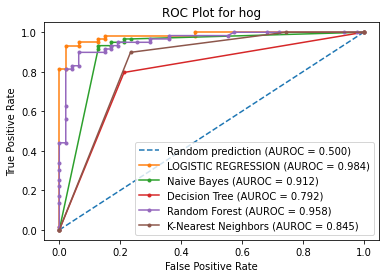

<Figure size 432x288 with 0 Axes>

In [25]:
#Plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='LOGISTIC REGRESSION (AUROC = %0.3f)' % logistic_auc)
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % gnb_auc)
plt.plot(DTC_fpr, DTC_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % DTC_auc)
plt.plot(RFC_fpr, RFC_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % RFC_auc)
plt.plot(neigh_fpr, neigh_tpr, marker='.', label='K-Nearest Neighbors (AUROC = %0.3f)' % neigh_auc)

# Title
plt.title('ROC Plot for hog')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()
plt.savefig('ROC curve for hog')